Wczytanie danych

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

## Informacje o datasecie

In [2]:
with open('mammographic_masses.names') as f:
    print(f.read())

1. Title: Mammographic Mass Data

2. Sources:

   (a) Original owners of database:
        Prof. Dr. Rüdiger Schulz-Wendtland
        Institute of Radiology, Gynaecological Radiology, University Erlangen-Nuremberg
        Universitätsstraße 21-23
        91054 Erlangen, Germany
        
   (b) Donor of database:
        Matthias Elter
        Fraunhofer Institute for Integrated Circuits (IIS)
        Image Processing and Medical Engineering Department (BMT) 
        Am Wolfsmantel 33
        91058 Erlangen, Germany
        matthias.elter@iis.fraunhofer.de
        (49) 9131-7767327 
        
   (c) Date received: October 2007
 
3. Past Usage:
    M. Elter, R. Schulz-Wendtland and T. Wittenberg (2007)
    The prediction of breast cancer biopsy outcomes using two CAD approaches that both emphasize an intelligible decision process.
    Medical Physics 34(11), pp. 4164-4172

4. Relevant Information:
    Mammography is the most effective method for breast cancer screening
    available today

## Czyszczenie datasetu, stadaryzacja, dekodowanie etykiet na wartości binarne

In [3]:
data = pd.read_csv('mammographic_masses.data', header=None)
data.head()

,0,1,2,3,4,5
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


In [4]:
data = data.rename(columns={0: 'BI-RADS assessment', 1 : 'Age', 2 : 'Shape', 3 : 'Margin', 4 : 'Density', 5 : 'Severity'})

In [5]:
data.head()

,BI-RADS assessment,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


Sprawdzenie czy są brakujące dane

In [6]:
print(data.isnull().values.any())

False


Widać że niektóre wartości są pouzupełniane stringami, mimo że wyszukanie pustych komórek zwraca false.
Puste wartości są stringami w postaci '?'

In [7]:
print("Liczba wartosci {} wynosi {}".format('?',np.count_nonzero(data.values == '?')))

Liczba wartosci ? wynosi 162


Usunięcie wszystkich wartości gdzie jest "?"

In [8]:
for column in data.columns:
    to_mean_calc = np.array(data.loc[data[column] != '?', column])
    to_mean_calc = to_mean_calc.astype('int32')
    data.loc[data[column] == '?', column] = np.mean(to_mean_calc).astype('int32')

print("Liczba wartosci {} wynosi {}".format('?',np.count_nonzero(data.values == '?')))

Liczba wartosci ? wynosi 0


# BI-RADS 
## BI-RADS jest zmienną która pozwala na względnie subiektywną ocenę złośliwości zmiany przez radiologa, ale jednocześnie cechuje się w części przypadków wysoką czułością w wykrywaniu nowotworu złośliwego
### BI-RADS równy 5 jest w 95% skuteczny według badań we wskazaniu zmian złośliwych
### BI-RADS assesment jest zmienną która wg opisu datasetu nie będzie używana do predykcji, stąd kolumnę można usunąć,
Stworzymy nowy dataframe na dane do przetwarzania.



In [9]:
dataset = data.copy()
dataset.drop('BI-RADS assessment', axis='columns', inplace = True)
dataset.head()

,Age,Shape,Margin,Density,Severity
0,67,3,5,3,1
1,43,1,1,2,1
2,58,4,5,3,1
3,28,1,1,3,0
4,74,1,5,2,1


Wszystkie dane są danymi kategorycznymi, stąd też zrzutujemy wszystkie tabele do inta, żeby zachować wartości klas

In [10]:
dataset = dataset.astype('int64')
dataset.dtypes

Age         int64
Shape       int64
Margin      int64
Density     int64
Severity    int64
dtype: object

Z racji zastosowania danych kategorycznych, zastosujemy OneHotEncoding tych danych

Tabela Age zostanie znormalizowana z uzyciem StandardScalera 
>Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)

>Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)

>Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)

>Age: int, należy znormalizować

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
scaler = StandardScaler()
dataset['Age'] = scaler.fit_transform(np.asarray(dataset['Age']).reshape(-1,1))
dataset.head()

,Age,Shape,Margin,Density,Severity
0,0.797726,3,5,3,1
1,-0.864912,1,1,2,1
2,0.174237,4,5,3,1
3,-1.904060,1,1,3,0
4,1.282661,1,5,2,1


In [12]:
dataset = pd.get_dummies(dataset, columns=['Shape'])
dataset.head()

,Age,Margin,Density,Severity,Shape_1,Shape_2,Shape_3,Shape_4
0,0.797726,5,3,1,0,0,1,0
1,-0.864912,1,2,1,1,0,0,0
2,0.174237,5,3,1,0,0,0,1
3,-1.904060,1,3,0,1,0,0,0
4,1.282661,5,2,1,1,0,0,0


In [13]:
dataset = pd.get_dummies(dataset, columns=['Margin'])
dataset.head()

,Age,Density,Severity,Shape_1,Shape_2,Shape_3,Shape_4,Margin_1,Margin_2,Margin_3,Margin_4,Margin_5
0,0.797726,3,1,0,0,1,0,0,0,0,0,1
1,-0.864912,2,1,1,0,0,0,1,0,0,0,0
2,0.174237,3,1,0,0,0,1,0,0,0,0,1
3,-1.904060,3,0,1,0,0,0,1,0,0,0,0
4,1.282661,2,1,1,0,0,0,0,0,0,0,1


In [14]:
dataset = pd.get_dummies(dataset, columns=['Density'])
dataset.head()

,Age,Severity,Shape_1,Shape_2,Shape_3,Shape_4,Margin_1,Margin_2,Margin_3,Margin_4,Margin_5,Density_1,Density_2,Density_3,Density_4
0,0.797726,1,0,0,1,0,0,0,0,0,1,0,0,1,0
1,-0.864912,1,1,0,0,0,1,0,0,0,0,0,1,0,0
2,0.174237,1,0,0,0,1,0,0,0,0,1,0,0,1,0
3,-1.904060,0,1,0,0,0,1,0,0,0,0,0,0,1,0
4,1.282661,1,1,0,0,0,0,0,0,0,1,0,1,0,0


Każda ostatnia wartość cech kodowanych binarnie jest nadmiarowa, zatem można ją usunąć

Przykład z Shape:

| Shape_1 | Shape_2 | Shape_3 | Shape_4 |
|---------|---------|---------|---------|
|   0     | 0       | 0       | 1       |



Jest tym samy co:

| Shape_1 | Shape_2 | Shape_3 |
|---------|---------|---------|
| 0       | 0       | 0       |



Dlatego mozna usunąć każdą ostatnią cechę


In [15]:
dataset = dataset[['Age', 'Shape_1', 'Shape_2', 'Shape_3', 'Margin_1', 'Margin_2', 'Margin_3', 'Margin_4',
                        'Density_1', 'Density_2', 'Density_3', 'Severity']]
dataset.head()

,Age,Shape_1,Shape_2,Shape_3,Margin_1,Margin_2,Margin_3,Margin_4,Density_1,Density_2,Density_3,Severity
0,0.797726,0,0,1,0,0,0,0,0,0,1,1
1,-0.864912,1,0,0,1,0,0,0,0,1,0,1
2,0.174237,0,0,0,0,0,0,0,0,0,1,1
3,-1.904060,1,0,0,1,0,0,0,0,0,1,0
4,1.282661,1,0,0,0,0,0,0,0,1,0,1


## Rozkład poszczególnych badanych parametrów z datasetu

> ile osób w jakim wieku?

> Średnia wieku, mediana, drugi moment statytyczny

>> Poszczególne wartości 1,2,3,4 należy odkodować za pomocą etykiet z opisu datasetu (nie dotyczy histogramu dla wieku osób)

Średnia wieku to: 55 lat


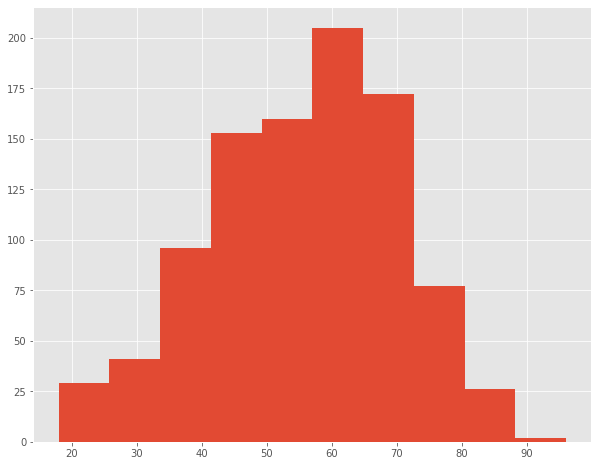

In [16]:
data = data.astype('int64')
age_of_people = np.array(data.iloc[:,1].values)
data['Age'].hist(figsize=(10,8))
print("Średnia wieku to: {:.0f} lat".format(age_of_people.mean()))

Opis danych za pomocą describe

In [17]:
data.describe()

,BI-RADS assessment,Age,Shape,Margin,Density,Severity
count,961.000000,961.000000,961.000000,961.000000,961.00000,961.000000
mean,4.347555,55.484912,2.698231,2.756504,2.83871,0.463059
std,1.781244,14.442416,1.229196,1.536711,0.44017,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.00000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.00000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.00000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.00000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.00000,1.000000


Rozkład wartości shape na historgramie

<AxesSubplot:>

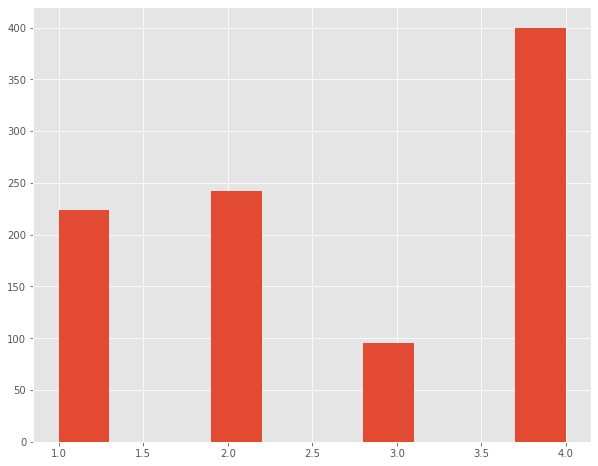

In [18]:
data['Shape'].hist(figsize=(10,8))


Rozkład parametru margin

<AxesSubplot:>

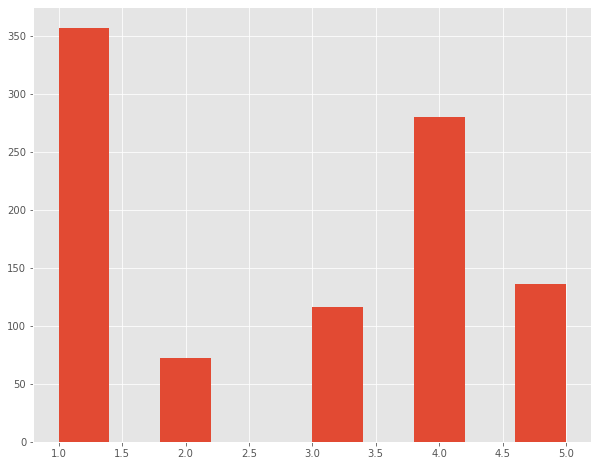

In [19]:
data['Margin'].hist(figsize=(10,8))

Rozkład parametru density

<AxesSubplot:>

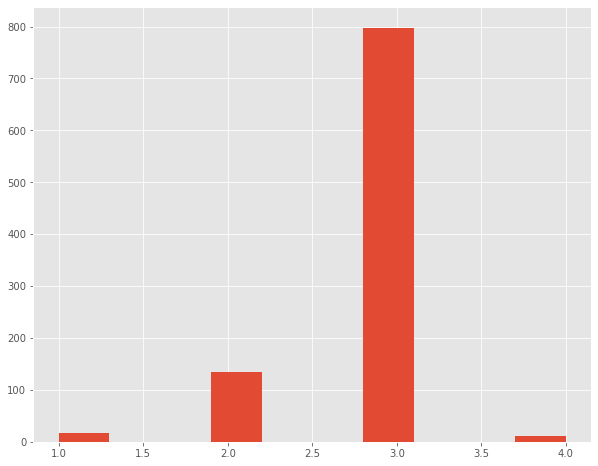

In [20]:
data['Density'].hist(figsize=(10,8))

Wykres współrzędnych równoległych (ang. *parallel coordinates plot*), który polega na przedstawieniu wszystkich wymiarów przetwarzanego zbioru danych w postaci pionowych osi liczbowych. Następnie każdy punkt na takim zestawie osi przedstawiany jest w postaci łamanej, która składa się z wartości danego punktu danych przypisanych do każdej z osi. 

Text(0.5, 1.0, 'Wizualizacja za pomocą wykresu w układzie równoległych współrzędnych')

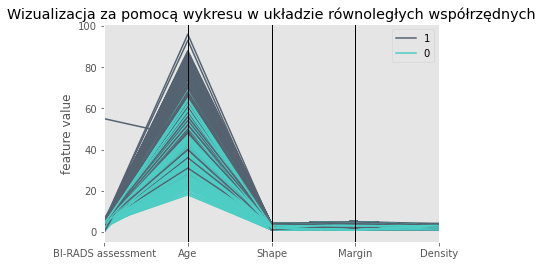

In [21]:
pd.plotting.parallel_coordinates(data, 'Severity', color=('#556270', '#4ECDC4'))
plt.ylabel('feature value')
plt.title('Wizualizacja za pomocą wykresu w układzie równoległych współrzędnych')

Wykres współrzędnych równoległych datasetu z znormalizoewanymi danymi oraz z podziałem na klasy binarne

Text(0.5, 1.0, 'Wizualizacja za pomocą wykresu w układzie równoległych współrzędnych')

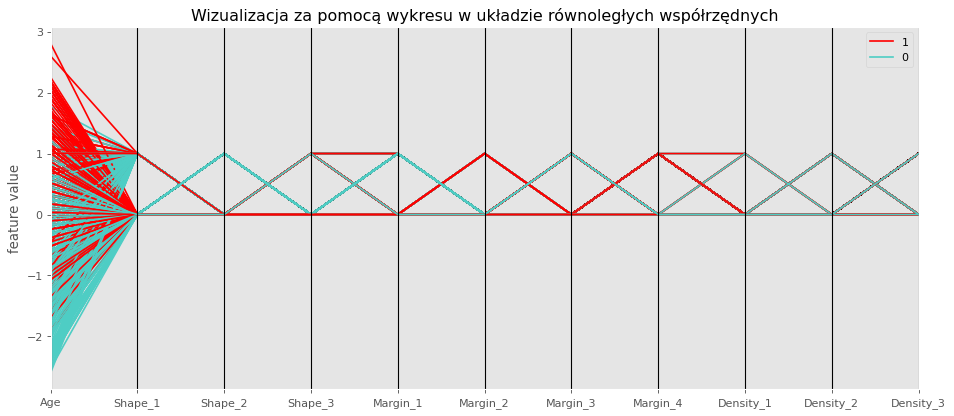

In [22]:
from matplotlib.pyplot import figure
figure(figsize=(14, 6), dpi=80)
pd.plotting.parallel_coordinates(dataset, 'Severity', color=('#FF0000', '#4ECDC4'))
plt.ylabel('feature value')
plt.title('Wizualizacja za pomocą wykresu w układzie równoległych współrzędnych')


Na wykresie widać że są zmienne które jednoznacznie wskazują na występowanie złośliwego raka

# Podział datasetu na dane treningowe i testowe
### zdecydowano się wykorzystać k-krotną walidację krzyżową zamiast sztywnego podziału na dane treningowe i testowe aby wyciągnąć średnie wielkości miar z badanego datasetu

In [23]:
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values
print("Rozmiar danych X: {}".format(X.shape))
print("Rozmiar danych y: {}".format(y.shape))

Rozmiar danych X: (961, 11)
Rozmiar danych y: (961,)


# Algorytm KNN

### Wyszukanie najlepszych parametrów dla algorytmu KNN 

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

knn_search = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn_search, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X, y)
knn_best_params = knn_gscv.best_params_.get('n_neighbors')

### Wytrenowanie klasyfikatora KNN z najlepszymi parametrami uczenia

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
knn_cv = KNeighborsClassifier(n_neighbors = knn_best_params)
scoring = {'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall',
           'f1' : 'f1'}
knn_cv_scores = cross_validate(knn_cv, X, y, cv = 5, scoring=scoring)

### Wyniki 5-krotnej walidacji krzyżowej  dla KNN

In [26]:
print("Srednia dokładność: {:2.4F} % z odchyleniem: {:0.4F}".format(np.mean(knn_cv_scores['test_acc']) * 100,
        np.std(knn_cv_scores['test_acc'])))
print("Średnia wartość F1: {:0.3F} z odchyleniem: {:0.4F}".format(np.mean(knn_cv_scores['test_f1']),
        np.std(knn_cv_scores['test_f1'])))

Srednia dokładność: 78.2556 % z odchyleniem: 0.0248
Średnia wartość F1: 0.781 z odchyleniem: 0.0269


Średnia wartość F1: 0.781 z odchyleniem: 0.0269


# Klasyfikator RFC

### W przypadku docelowego algorytmu RFC również zdecydowano się GridSearch do znalezenia optymalnych parametrów trenigu.

In [27]:
from sklearn.ensemble import RandomForestClassifier
rfc_search = RandomForestClassifier()
grid_values = {'n_estimators': [10, 30, 50, 100, 120, 150],
               'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
               'max_depth' : np.arange(2,22,2)
              }

rfc_gscv = GridSearchCV(rfc_search, param_grid = grid_values, scoring = 'accuracy')
rfc_gscv.fit(X,y)
rfc_best_params = rfc_gscv.best_params_

### Wytrenowanie klasyfikatora

In [30]:
rfc_cv = RandomForestClassifier(n_estimators=rfc_best_params['n_estimators'], 
        max_features=rfc_best_params['max_features'], max_depth = rfc_best_params['max_depth'])
rfc_cv_scores = cross_validate(rfc_cv, X, y, scoring = scoring,cv = 5)      

### Wyniki 5-krotnej walidacji krzyżowej dla RFC

In [32]:
print("Srednia dokładność: {:2.4F} % z odchyleniem: {:0.4F}".format(np.mean(rfc_cv_scores['test_acc']) * 100,
        np.std(rfc_cv_scores['test_acc'])))
print("Średnia wartość F1: {:0.3F} z odchyleniem: {:0.4F}".format(np.mean(rfc_cv_scores['test_f1']),
        np.std(rfc_cv_scores['test_f1'])))        

Srednia dokładność: 79.8154 % z odchyleniem: 0.0190
Średnia wartość F1: 0.793 z odchyleniem: 0.0222


# Klasyfikator SVM
### zdecydowano się również na przetestowanie SVM, z racji niskiego progresu skuteczności klasyfikacji RFC w stosunku do klasyfikacji KNN

In [28]:
from sklearn.svm import SVC
svm_search = SVC()
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
svm_gscv = GridSearchCV(svm_search, param_grid=param_grid, cv = 5)
svm_gscv.fit(X,y)

svm_best_params = svm_gscv.best_params_

### Wytrenowanie klasyfikatora

In [29]:
svm_cv = SVC(C = svm_best_params['C'], gamma = svm_best_params['gamma'],
                 kernel = svm_best_params['kernel'])
svm_cv_scores = cross_validate(svm_cv, X, y, scoring = scoring, cv = 5)

### Wyniki 5-krotnej walidacji krzyżowej dla SVM

In [31]:
print("Srednia dokładność: {:2.4F} % z odchyleniem: {:0.4F}".format(np.mean(svm_cv_scores['test_acc']) * 100,
        np.std(svm_cv_scores['test_acc'])))
print("Średnia wartość F1: {:0.3F} z odchyleniem: {:0.4F}".format(np.mean(svm_cv_scores['test_f1']),
        np.std(svm_cv_scores['test_f1'])))    

Srednia dokładność: 79.7107 % z odchyleniem: 0.0155
Średnia wartość F1: 0.787 z odchyleniem: 0.0212
